In [27]:
import hopsworks
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import ensemble
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import numpy as np
from sklearn.metrics import mean_squared_error

import datetime as dt
import calendar
import datetime
from datetime import datetime, timedelta, date

In [3]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/224406
Connected. Call `.close()` to terminate connection gracefully.


In [29]:

dataframes = []

base_dir = '/Users/robingoran/Downloads/archive/'

for dirname, _, filenames in os.walk(base_dir):
    for filename in filenames:
        file = filename.split('.')
        file = f"{file[0]}_df"
        if file != "_df":
            filepath = os.path.join(dirname, filename)
            df = pd.read_csv(filepath, sep=",", encoding="UTF-8")
            exec(f'{file} = df.copy()')
            print(file, df.shape)
            dataframes.append(df)

print('Data imported')

game_lineups_df (129837, 9)
competitions_df (43, 10)
appearances_df (1513742, 13)
player_valuations_df (458187, 7)
game_events_df (670643, 10)
players_df (30324, 23)
games_df (65475, 23)
club_games_df (130950, 11)
clubs_df (426, 17)
Data imported


Structure of data

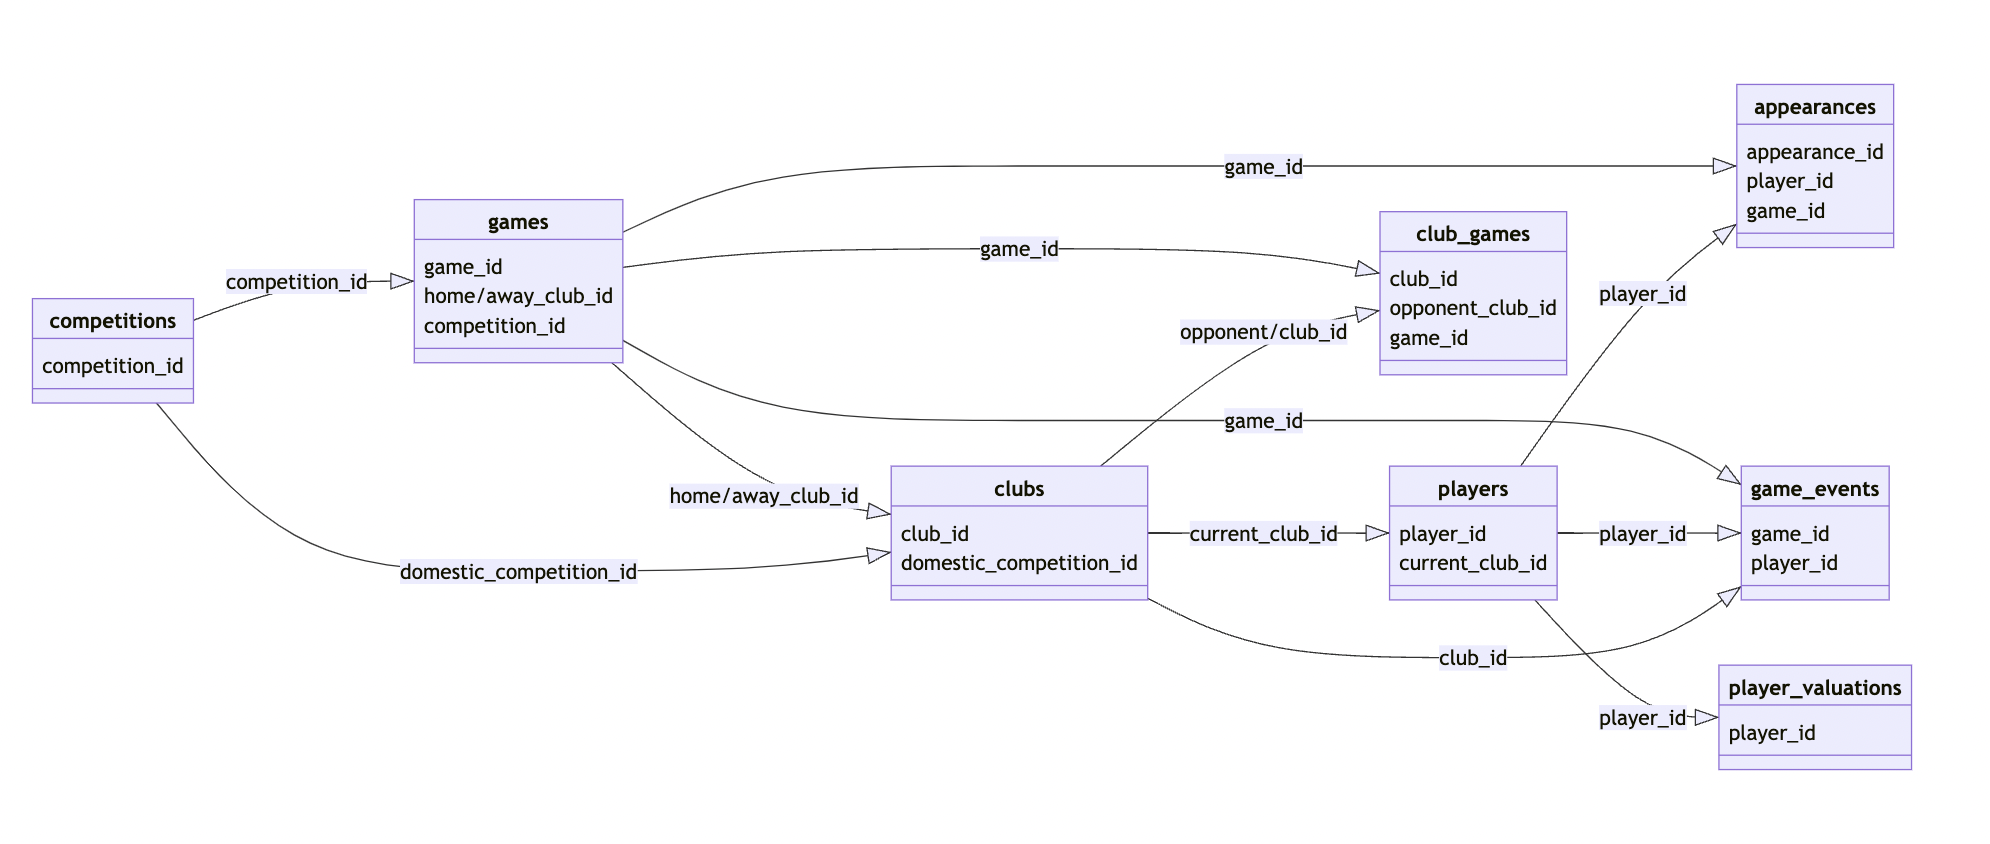


The goal is to create a feature group where every sample is one transfer. The target will be the transfer fee, and the rest of the features will be factors that are thought to have an impact on the transfer value. This will be player attributes such as height, position. Player statistics such as goals and assists during the x last seasons, but also minutes played, amount of wins etc. More formal features such as the player's contract length etc will also be included. The data is not structured this way. We will need to aggregate each transfer with the relevant player, and the features for this player at the time of the transfer. 

In [19]:
player_valuations_df


,player_id,date,datetime,dateweek,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,405973,2000-01-20,2000-01-20 00:00:00,2000-01-17,150000,3057.0,BE1
1,342216,2001-07-20,2001-07-20 00:00:00,2001-07-16,100000,1241.0,SC1
2,3132,2003-12-09,2003-12-09 00:00:00,2003-12-08,400000,126.0,TR1
3,6893,2003-12-15,2003-12-15 00:00:00,2003-12-15,900000,984.0,GB1
4,10,2004-10-04,2004-10-04 00:00:00,2004-10-04,7000000,398.0,IT1
...,...,...,...,...,...,...,...
458182,990590,2023-12-05,2023-12-05 00:00:00,2023-12-04,300000,1241.0,SC1
458183,1001854,2023-12-05,2023-12-05 00:00:00,2023-12-04,50000,903.0,SC1
458184,1031044,2023-12-05,2023-12-05 00:00:00,2023-12-04,250000,2759.0,SC1
458185,1041600,2023-12-05,2023-12-05 00:00:00,2023-12-04,100000,43.0,SC1


In [32]:
player_valuations_df['date'] = pd.to_datetime(player_valuations_df['date'])

2023-12-11 13:48:28,619 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-12-11 13:48:28,625 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



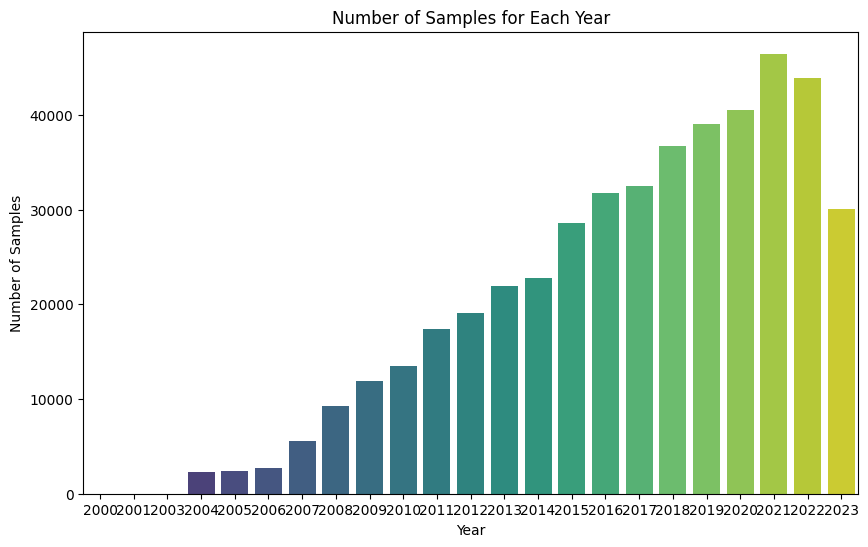

In [33]:
yearly_counts = player_valuations_df['date'].dt.year.value_counts().sort_index().reset_index()
yearly_counts.columns = ['Year', 'Number of Samples']

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='Number of Samples', data=yearly_counts, palette='viridis')
plt.title('Number of Samples for Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Samples')
plt.show()

As the year in which the transfer occured is deemed to be relevant, we only include years which have at least 10000 samples, meaning from 2008 and forward.

In [64]:
player_valuations_df = player_valuations_df[player_valuations_df['date'].dt.year >= 2021]

player_valuations_df

,player_id,date,datetime,dateweek,market_value_in_eur,current_club_id,player_club_domestic_competition_id
337844,38000,2021-01-01,2021-01-01 00:00:00,2020-12-28,150000,2861.0,BE1
337845,66613,2021-01-01,2021-01-01 00:00:00,2020-12-28,150000,441.0,GR1
337846,74253,2021-01-01,2021-01-01 00:00:00,2020-12-28,50000,1025.0,IT1
337847,106181,2021-01-01,2021-01-01 00:00:00,2020-12-28,250000,3558.0,FR1
337848,126673,2021-01-01,2021-01-01 00:00:00,2020-12-28,3500000,1025.0,IT1
...,...,...,...,...,...,...,...
458182,990590,2023-12-05,2023-12-05 00:00:00,2023-12-04,300000,1241.0,SC1
458183,1001854,2023-12-05,2023-12-05 00:00:00,2023-12-04,50000,903.0,SC1
458184,1031044,2023-12-05,2023-12-05 00:00:00,2023-12-04,250000,2759.0,SC1
458185,1041600,2023-12-05,2023-12-05 00:00:00,2023-12-04,100000,43.0,SC1


Process of understanding what each table contains, and cleaning irrelevant columns

game_lineups_df (129837, 9) Done
competitions_df (43, 10) Done
appearances_df (1513742, 13)
player_valuations_df (458187, 7)
game_events_df (670643, 10)
players_df (30324, 23)
games_df (65475, 23)
club_games_df (130950, 11)
clubs_df (426, 17)
Data imported

In [ ]:
#No. of different position could be a good feature to use. The most frequent position will also be used as a categorical feature, 
#however split up in only [Forward, Midfielder, Defender, Goalkeeper]
game_lineups_df

In [ ]:
game_lineups_df=game_lineups_df.drop(['game_lineups_id', 'number', 'player_name', 'team_captain'], axis=1)


In [ ]:
#could be used to differ between stats in different leagues? Meaning different features for domestic league and international ones.
competitions_df

In [62]:
filtered_df = appearances_df[appearances_df['player_name'] == "Federico Valverde"]

# Display or use the filtered DataFrame 'filtered_df'
print(filtered_df)

          appearance_id  game_id  player_id  player_club_id  \
677820   2899574_369081  2899574     369081             897   
680379   2899587_369081  2899587     369081             897   
683197   2899597_369081  2899597     369081             897   
686863   2899599_369081  2899599     369081             897   
689515   2899611_369081  2899611     369081             897   
...                 ...      ...        ...             ...   
1500695  4113096_369081  4113096     369081             418   
1505671  4113077_369081  4113077     369081             418   
1506874  4171251_369081  4171251     369081             418   
1508547  4113169_369081  4113169     369081             418   
1513267  4112876_369081  4112876     369081             418   

         player_current_club_id        date        player_name competition_id  \
677820                      418  2017-09-10  Federico Valverde            ES1   
680379                      418  2017-09-16  Federico Valverde            ES1   


In [ ]:
appearances_df=appearances_df.drop(['appearance_id', 'game_id'], axis=1)

In [59]:
#Contains information like player length.
players_df

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,right,184.0,NaN,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,left,190.0,NaN,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.0,8000000.0
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,NaN,NaN,NaN,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0
3,77,NaN,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,NaN,NaN,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,200000.0,24500000.0
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,right,194.0,NaN,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,100000.0,3000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30319,1162979,Ali Kemal,Aslankaya,Ali Kemal Aslankaya,2023,126,ali-kemal-aslankaya,Turkey,Rize,Turkey,...,right,NaN,2025-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/ali-kemal-asla...,TR1,Çaykur Rizespor Kulübü,50000.0,50000.0
30320,1163778,Kahveh,Zahiroleslam,Kahveh Zahiroleslam,2023,475,kahveh-zahiroleslam,United States,"Saratoga, California",United States,...,right,193.0,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/kahveh-zahirol...,BE1,Koninklijke Sint-Truidense Voetbalvereniging,250000.0,250000.0
30321,1166093,Georgios,Konstantakopoulos,Georgios Konstantakopoulos,2023,30120,georgios-konstantakopoulos,NaN,NaN,Greece,...,both,182.0,2026-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/georgios-konst...,GR1,Athlitiki Enosi Kifisias,50000.0,50000.0
30322,1173042,Djibi,Seck,Djibi Seck,2023,601,djibi-seck,NaN,NaN,Senegal,...,NaN,NaN,2025-06-30 00:00:00,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/djibi-seck/pro...,BE1,Koninklijke Voetbalclub Kortrijk,100000.0,100000.0


In [60]:
players_df=players_df.drop(['first_name', 'last_name', 'name', 'last_season', 'player_code', 'country_of_birth', 'city_of_birth',
                            'agent_name', 'image_url', 'url', 'current_club_name', 'highest_market_value_in_eur'], axis=1)

In [51]:
games_df

,game_id,competition_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,stadium,attendance,referee,url,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type
0,2222597,RU1,2012,6. Matchday,2012-08-25,3725,232,2,1,2.0,...,Akhmat-Arena,21700.0,Vladislav Bezborodov,https://www.transfermarkt.co.uk/terek-grozny_s...,NaN,NaN,RFK Akhmat Grozny,FK Spartak Moskva,2:1,domestic_league
1,2222627,RU1,2012,5. Matchday,2012-08-20,2696,4128,0,2,11.0,...,Metallurg,11400.0,Sergey Ivanov,https://www.transfermarkt.co.uk/krylya-sovetov...,NaN,NaN,PFK Krylya Sovetov Samara,Amkar Perm,0:2,domestic_league
2,2222658,RU1,2012,10. Matchday,2012-09-30,2410,121,0,2,2.0,...,Arena Khimki,12000.0,Sergey Karasev,https://www.transfermarkt.co.uk/cska-moscow_di...,NaN,NaN,PFK CSKA Moskva,FK Dinamo Moskva,0:2,domestic_league
3,2222664,RU1,2012,8. Matchday,2012-09-15,932,2698,1,0,5.0,...,RZD Arena,11408.0,Sergey Karasev,https://www.transfermarkt.co.uk/lokomotiv-mosc...,NaN,NaN,"Футбольный клуб ""Локомотив"" Москва",FC Rubin Kazan,1:0,domestic_league
4,2222683,RU1,2012,12. Matchday,2012-10-22,2696,12438,0,1,11.0,...,Metallurg,7534.0,Timur Arslanbekov,https://www.transfermarkt.co.uk/krylya-sovetov...,NaN,NaN,PFK Krylya Sovetov Samara,Volga Nizhniy Novgorod (- 2016),0:1,domestic_league
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65470,2367292,EL,2013,Group B,2013-11-07,383,419,2,0,NaN,...,Philips Stadion,10000.0,Cristian Balaj,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,Eindhovense Voetbalvereniging Philips Sport Ve...,NaN,2:0,international_cup
65471,2629035,NLP,2015,Third Round,2015-10-27,383,16866,6,0,NaN,...,Philips Stadion,31000.0,Allard Lindhout,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,Eindhovense Voetbalvereniging Philips Sport Ve...,NaN,6:0,domestic_cup
65472,3092951,CLQ,2018,Qualifying Round 2nd leg,2018-08-29,383,713,3,0,NaN,...,Philips Stadion,34200.0,Anthony Taylor,https://www.transfermarkt.co.uk/spielbericht/i...,NaN,NaN,Eindhovense Voetbalvereniging Philips Sport Ve...,NaN,3:0,international_cup
65473,4164101,CGB,2023,Second Round,2023-08-29,512,1194,6,1,NaN,...,bet365 Stadium,9410.0,Michael Salisbury,https://www.transfermarkt.co.uk/spielbericht/i...,4-2-3-1,4-2-3-1,Stoke City,NaN,6:1,other
